In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.style as style
from pylab import rcParams
from scipy import stats
%matplotlib inline

In [2]:
data = pd.read_csv('top250.csv')
data.tail(3)

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
4697,Silvan Widmer,Right-Back,25,Udinese Calcio,Serie A,FC Basel,Super League,2018-2019,8500000.0,4500000
4698,Yuya Osako,Second Striker,28,1. FC Köln,2.Bundesliga,Werder Bremen,1.Bundesliga,2018-2019,4500000.0,4500000
4699,Kyle Bartley,Centre-Back,27,Swansea,Championship,West Brom,Championship,2018-2019,3500000.0,4500000


Для начала небольшое описание датасета: <br>
Name: Фамилия Имя футболиста <br>
Position: Номинальная зона на поле, в которой действует игрок. "Профессия" игрока. <br>
Age: Возраст <br>
Team_from: Из какой команды был продан <br>
League_from: В какой лиге играл <br>
Team_to: В какую команду был куплен <br>
League_to: В какую лигу был куплен <br>
Season: В каком сезоне состоялась сделка. Сезон играется период с августа по июнь, года описывают сроки сезона<br>
Market_value: Прогнозная стоимость футболиста, исходя из его профессиональных качеств. Рыночную стоимость каждый источник/специалист считает по своим алгоритмам и схемам<br>
Transfer_fee: фактическая стоимость сделки, сколько денег один клуб передал другому. 

In [3]:
data.Season = data.Season.str[-2:]
data.Season = data.Season.astype('int')

Перед нами датасет, который содержит информацию о топ 250 самых дорогих переходах футболистов из одной команды в другую. 
Всего перед нами 4700 наблюдений, которые содержат основную информацию о трансфере.
Какой-то конкретной задачи я перед собой не ставил, просто попробуем "покрутить" данные, используя изученные ранее методы.
Как мы видим, в нашем датасете в основном представлены категориальные признаки.

#### Гипотеза 1. Позиция игрока влияет на его трансферную стоимость.
Позиция игрока - это категориальная переменная. Для проверки данной гипотезы мы будем пользоваться однофакторным дисперсионным анализом. 
В качестве нулевой гипотезы берется утверждение, что средние цены игроков по позициям будут равны

In [4]:
# предварительно удаляем наблюдения, которые содержат неполную информацию о позиции
trash = ['Forward', 'Sweeper', 'Defender', 'Midfielder']
data = data.loc[~data.Position.isin(trash)]

In [5]:
# вытаскиваем список уникальных позиций
positions = data.Position.unique()

In [6]:
round(data.groupby('Position').mean()['Transfer_fee']).sort_values(ascending=False)

Position
Left Winger           12904644.0
Right Winger          11930361.0
Central Midfield      10096242.0
Attacking Midfield     9824178.0
Centre-Forward         9590271.0
Defensive Midfield     8992019.0
Second Striker         8790154.0
Centre-Back            8448592.0
Right-Back             8254309.0
Left-Back              7718933.0
Goalkeeper             7622667.0
Right Midfield         7404127.0
Left Midfield          6717126.0
Name: Transfer_fee, dtype: float64

Мы видим явное расхождение по стоимости игроков среди разных амплуа.
<br>
Построим графики распределения цен игроков по их позициям.

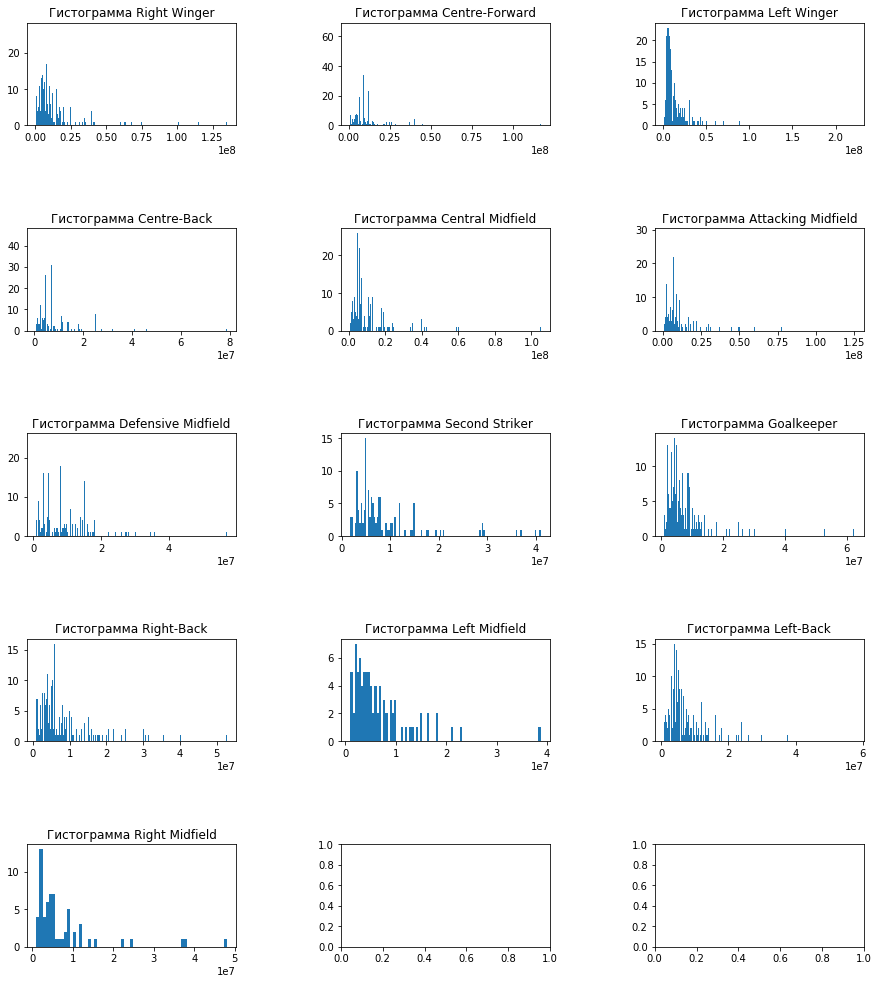

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=3)
axf = ax.flatten()
for i,pos in enumerate(positions[:]):
    axf[i].hist(data.Transfer_fee[data.Position == pos], bins=data.Transfer_fee[data.Position == pos].shape[0])
    axf[i].set_title(f'Гистограмма {pos}')
fig.set_size_inches(15,17)
plt.subplots_adjust(wspace=0.5,hspace=1)

Мы видим, что гистограммы "на глаз" различаются

In [8]:
k = positions.size # количество выборок
n = data.shape[0] # общее количество наблюдений
y = data.Transfer_fee.mean() # среднее по выборке

$$S_b^2 = \displaystyle\sum_{i=1}^k (\overline{y}_i - \overline{y})^2 n_i, \:\:
S_w^{2} = \displaystyle\sum_{i=1}^k \displaystyle\sum_{j=1}^{n_i} (y_{ij} - \overline{y}_i)^2$$

In [9]:
S2_b = 0
for i in positions:
    y_i = data.Transfer_fee[data.Position == i].mean()
    n1 = data[data.Position == i].shape[0]
    S2_b += ((y_i - y)**2 * n1)

In [10]:
S2_w = 0
for i in positions:
    y_i = data.Transfer_fee[data.Position == i].mean()
    S2_w += ((data.Transfer_fee[data.Position==i] - y_i)**2).sum()

$$\sigma_b^2 = \dfrac{S_b^2}{k - 1}, \:\: \sigma_w^2 = \dfrac{S_w^2}{n - k}$$

In [11]:
k1 = k-1
k2 = n-k
sigma2_b = S2_b / (k-1)
sigma2_w = S2_w / (n-k)
sigma2_b, sigma2_w

(721336215304666.0, 107444182854176.77)

In [12]:
F = sigma2_b / sigma2_w
F

6.713590220921159

In [13]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

1.7542367531296175

$F > F_{crit}$, поэтому отвергаем нулевую гипотезу, и делаем вывод, что стоимость игрока зависит от его позиции на поле

#### 1.1 Повторим проделанную процедуру, но сузим список амплуа до игроков середины поля.
Делаем мы это для того, чтобы понять - действительно ли важна конкретная позиция на поле, или только определенные области на поле и функции игрока. То есть мы предполагаем, что на самом деле разница суммы трансфера обусловена более общим делением на группы (нападающий, полузащитник, защитник, вратарь), а внутри этих групп разницы не будет.

In [14]:
round(data.groupby('Position').mean()['Transfer_fee']).sort_values(ascending=False)

Position
Left Winger           12904644.0
Right Winger          11930361.0
Central Midfield      10096242.0
Attacking Midfield     9824178.0
Centre-Forward         9590271.0
Defensive Midfield     8992019.0
Second Striker         8790154.0
Centre-Back            8448592.0
Right-Back             8254309.0
Left-Back              7718933.0
Goalkeeper             7622667.0
Right Midfield         7404127.0
Left Midfield          6717126.0
Name: Transfer_fee, dtype: float64

In [15]:
# позиции выбраны исключительно моим видением распределения ролей в данной игре,
# подробно описывать что и почему не имеет смысла в рамках работы по статистике :) 
midfielders = ['Central Midfield', 'Attacking Midfield', 'Defensive Midfield']

In [16]:
km = len(midfielders) # количество выборок
nm = data.Transfer_fee[data.Position.isin(midfielders)].shape[0] # общее количество наблюдений
ym = data.Transfer_fee[data.Position.isin(midfielders)].mean() # среднее по выборке

In [17]:
Sm2_b = 0
for i in midfielders:
    y_i = data.Transfer_fee[data.Position == i].mean()
    nm1 = data[data.Position == i].shape[0]
    Sm2_b += ((y_i - ym)**2 * nm1)

In [18]:
Sm2_w = 0
for i in midfielders:
    y_i = data.Transfer_fee[data.Position == i].mean()
    Sm2_w += ((data.Transfer_fee[data.Position==i] - y_i)**2).sum()

In [19]:
km1 = km-1
km2 = nm-km
sigmam2_b = Sm2_b / (km-1)
sigmam2_w = Sm2_w / (nm-km)
sigmam2_b, sigmam2_w

(143751573816031.22, 99998308258663.31)

In [20]:
Fm = sigmam2_b / sigmam2_w
Fm

1.4375400576196984

In [21]:
alpha = 0.05

Fm_crit = stats.f.ppf(1 - alpha, km1, km2)
Fm_crit

3.0025362063516057

Как видим, $F < F_{crit}$, значит гипотеза о том, что средние зарплаты среди групп 'Central Midfield', 'Attacking Midfield', 'Defensive Midfield', равны, верна. <br><br>
Наверное, это немного запутанно для человека, который не увлекается данным спортом, но логика примерно следующая: есть зона, в которой играет футболист, и внутри зоны есть специализации. Исходя из нашего анализа мы получили вывод о том, что важна именно игровая зона футболиста, но специализация внутри этой зоны не влияет на его стоимость на трансферном рынке.

#### 2. Взаимосвязь величин Market_value и Transfer_fee
Рыночная стоимость игрока - это прогноз, который делает тот или иной специалист, основываясь на своих методах и данных.
Трансферная стоимость - это фактическая стоимость совершенной сделки. Мы хотим понять, насколько взаимосвязаны данные величины. <br>
Для начала посмотрим на средние значения данных признаков, а так же посмотрим на их корреляцию. Также оценим остальные признаки, которые можно попробовать использовать для предсказания стоимости трансфера

In [22]:
# Market_value содержит некоторое количество Nan
data.Market_value[data.Market_value > 0].mean(), data.Transfer_fee.mean()

(8622469.476744186, 9457110.140605027)

In [23]:
data[['Market_value', 'Transfer_fee', 'Season', 'Age']][data.Market_value > 0].corr()

,Market_value,Transfer_fee,Season,Age
Market_value,1.000000,0.830573,0.211755,0.142739
Transfer_fee,0.830573,1.000000,0.303738,-0.020617
Season,0.211755,0.303738,1.000000,-0.018722
Age,0.142739,-0.020617,-0.018722,1.000000


Мы видим, что корреляция между Market_value и целевой переменной очень высокая. Построим графики зависимости стоимости от заданных переменных

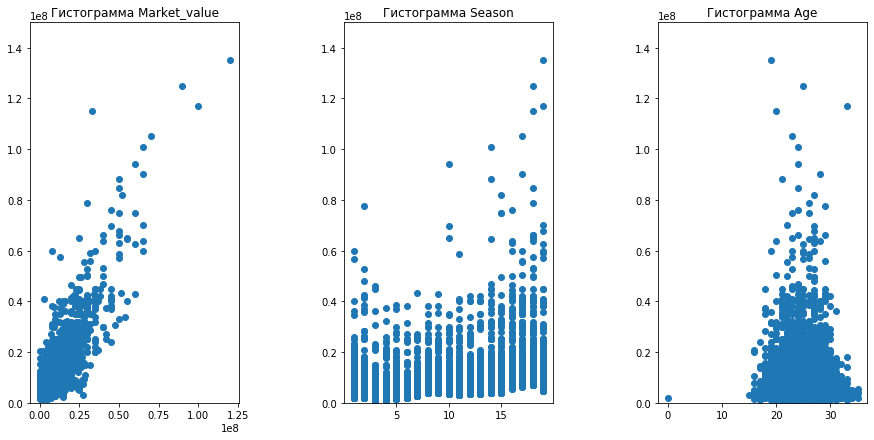

In [24]:
cols =['Market_value', 'Season', 'Age']
fig, ax = plt.subplots(nrows=1, ncols=3)
axf = ax.flatten()
for i, y in enumerate(cols[:]):
    axf[i].scatter(data[y], data.Transfer_fee)
    axf[i].set_title(f'Гистограмма {y}')
    axf[i].set_ylim(0, 150000000)
fig.set_size_inches(15,7)
plt.subplots_adjust(wspace=0.5,hspace=1)

На графиках мы видим, явный рост Transfer_fee вместе с ростом Market_value, что согласуется с высоким коэффициентом корреляции. <br>
В случае с признаком Season рост так же наблюдается, но менее выраженный. Так, с течением времени стоимость увеличивается, но незначительно.<br>
А вот возрастом интереснее - пик стоимости футболиста приходится на 25 лет, до этого момента цена растет. После - падает. Это вполне согласуется со здравым смыслом, однако нам это говорит о том, что возраст не стоит использовать в качестве признака для регрессии. <br>
На самом деле год, как количественный показатель, это тоже сомнительный признак для регрессии, но в рамках данного дата-сета я закрываю на это глаза

In [25]:
# создадим для удобства две матрицы
X = data[['Season', 'Market_value']][data.Market_value > 0].values
Y = data['Transfer_fee'][data.Market_value > 0].values

Дальше считаем коэффициенты регрессии через МНК, без особых отличий от методички

In [26]:
ones = np.ones((X.shape[0], 1))
X = np.hstack((ones, X))

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score #Готовая функция для оценки качества

Мы будем строить нашу модель лишь на части данных, для того чтобы потом попробовать сделать реальное предсказание на оставшейся доле данных.

In [28]:
# разбиваем наши данные на обучающую, и проверочную выборку, н
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

In [29]:
XTX = x_train.T.dot(x_train)
np.linalg.det(XTX)

1.5010537020221411e+25

In [30]:
XTX_inv = np.linalg.inv(XTX)
b = XTX_inv.dot(x_train.T).dot(y_train)
b

array([-2.57327546e+06,  3.73838285e+05,  9.90555176e-01])

In [31]:
# по полученным коэффициентам предскажем значения для тестовой части выборки
y_pred = x_test.dot(b)

Оценим качество модели через функцию r2_score, и вручную по формуле Коэффициента детерминации:
$$R^2 = 1 - \dfrac{\sigma^2_{res}}{\sigma^2_{y}}$$

In [32]:
r2_score(y_test, y_pred), 1 - ( (y_pred - y_test).var() / y_test.var())

(0.7105715398968431, 0.7106243381069608)

Мы видим достаточно высокий показатель метрики качества, а значит рыночная стоимость игрока и его возраст - это определяющие показатели для предсказания суммы фактического трансфера.

#### 3. Изучим, какие лиги больше всего тратят  покупку игроков, а какие больше всего зарабатывают на их продаже. А так же средние суммы за сделку.

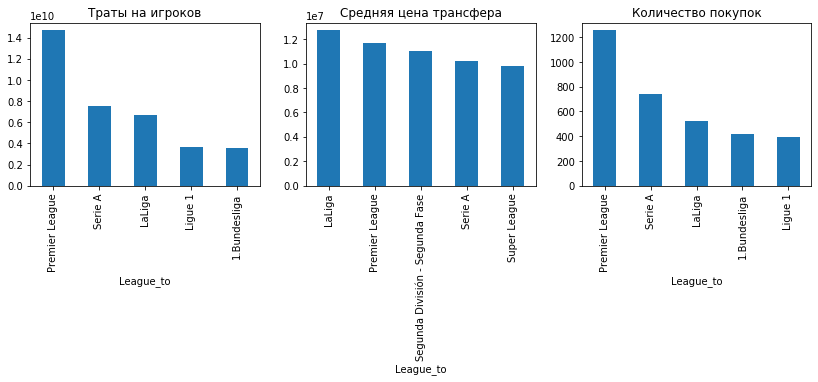

In [33]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 3, 1)
plt.title('Траты на игроков')

data.groupby('League_to')['Transfer_fee'].sum().sort_values(ascending=False)[:5].plot(kind='bar')

plt.subplot(1, 3, 2)
plt.title('Средняя цена трансфера')
data.groupby('League_to')['Transfer_fee'].mean().sort_values(ascending=False)[:5].plot(kind='bar')


plt.subplot(1, 3, 3)
plt.title('Количество покупок')
data.groupby('League_to')['Transfer_fee'].count().sort_values(ascending=False)[:5].plot(kind='bar')

plt.show()

Из графиков мы видим, что Премьер лига безусловный фаворит потраченным деньгам, и по количеству игроков. С другой стороны, по дороговизне трансферов с небольшим отрывом лидирует Ла Лига <br>
Аналогичным образом выявим, какие лиги лучше всего зарабатывают деньги на продаже футболистов.

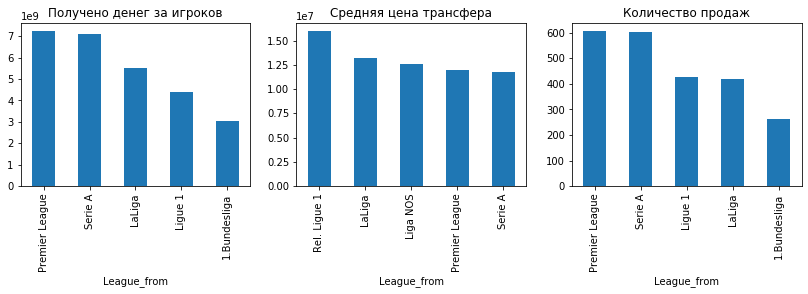

In [34]:
plt.figure(figsize=(14, 3))

plt.subplot(1, 3, 1)
plt.title('Получено денег за игроков')

data.groupby('League_from')['Transfer_fee'].sum().sort_values(ascending=False)[:5].plot(kind='bar')

plt.subplot(1, 3, 2)
plt.title('Средняя цена трансфера')
data.groupby('League_from')['Transfer_fee'].mean().sort_values(ascending=False)[:5].plot(kind='bar')


plt.subplot(1, 3, 3)
plt.title('Количество продаж')
data.groupby('League_from')['Transfer_fee'].count().sort_values(ascending=False)[:5].plot(kind='bar')

plt.show()

И снова Премьер лига - самый активный игрок на рынке как по общему обороту, так и по количеству сделок. <br>
Зато в графике "Средняя цена трансфера" мы видим двух новых игроков - <b>Rel. Ligue 1</b> и <b>Liga NOS</b> <br>
Можно предположить, что клубы из этой лиги зарабатывают на том, что выращивают футболистов и выгодно их продают. Проверим:

In [38]:
data.Transfer_fee[data.League_from == 'Rel. Ligue 1'].sum() - data.Transfer_fee[data.League_to == 'Rel. Ligue 1'].sum()

32000000

In [49]:
data.Transfer_fee[data.League_from == 'Rel. Ligue 1'].shape, data.Transfer_fee[data.League_to == 'Rel. Ligue 1'].shape

((2,), (0,))

Мы видим, что выборка по лиге "Rel. Ligue 1" слишком мала, чтобы считать её значимой. Проверим второго кандидата

In [39]:
data.Transfer_fee[data.League_from == 'Liga NOS'].sum() - data.Transfer_fee[data.League_to == 'Liga NOS'].sum()

1432120000

In [47]:
data.Transfer_fee[data.League_from == 'Liga NOS'].shape, data.Transfer_fee[data.League_to == 'Liga NOS'].shape

((178,), (127,))

По данной лиге всё в порядке. Действительно, игроки уходят из лиги чаще чем приходят в неё, а трансферная прибыль впечатляет. <br> Напоследок посмотрим самые дорогие продажи из данной лиги, чтобы знать героев в лицо

In [56]:
data[data.League_from == 'Liga NOS'].sort_values(['Transfer_fee'], ascending=False)[:5]

,Name,Position,Age,Team_from,League_from,Team_to,League_to,Season,Market_value,Transfer_fee
3221,James Rodríguez,Attacking Midfield,21,FC Porto,Liga NOS,Monaco,Ligue 1,14,23000000.0,45000000
2722,Falcao,Centre-Forward,25,FC Porto,Liga NOS,Atlético Madrid,LaLiga,12,25000000.0,40000000
2970,Hulk,Right Winger,26,FC Porto,Liga NOS,Zenit S-Pb,Premier Liga,13,37000000.0,40000000
2973,Axel Witsel,Central Midfield,23,Benfica,Liga NOS,Zenit S-Pb,Premier Liga,13,20000000.0,40000000
4231,Ederson,Goalkeeper,23,Benfica,Liga NOS,Man City,Premier League,18,22000000.0,40000000
